In [1]:
%load_ext autoreload
%autoreload 2

DATA_DIR = '../data/'

# Explore the columns of data and find outliers
import pandas as pd
import os
import os.path as osp
from typing import Optional
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../')

In [2]:
# Visualization libraries
from source.utils.visualization import *
from source.utils.preprocessing import *
SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}

setup_plotting_icml2022(
    **plot_kwargs
    )

# Regional Correlation Visualizations
This notebook explores the similarity between different regions (country) and their popularity-audio features correlations. First, lets load the saved correlation object that has the following structure:

```dict(country : [pearson, spearman, kendall])```

In [3]:
import pickle
CORRELATION_PICKLE_PATH = osp.join(DATA_DIR,'correlations/correlations_2017_2022_top_200.pickle')
PICKLE_LABEL = '2017_2022_top_200'
assert os.path.exists(CORRELATION_PICKLE_PATH), 'Check the pathing to the correlation pickle file'

# Load the data
with open(CORRELATION_PICKLE_PATH, 'rb') as f:
    df = pickle.load(f)

In [4]:
# This seperation is predefined while saving the pickle
df_corr = {k:v[0] for k,v in df.items()}
df_spearman = {k:v[1] for k,v in df.items()}
df_kendall = {k:v[2] for k,v in df.items()}

After loading data, we can explore how the correlations are distributed with a violin plot.

In [5]:
from matplotlib import cm

def plot_correlation(df : pd.DataFrame, 
                     method : str ="Pearson",
                     show_extremes: bool = True,
                     save_path : Optional[str] = None,
                     show : bool = True,
                     **plot_kwargs
                     ):
    """
    Plots the correlation between popularity and audio features for different regions.

    Parameters:
    - df: DataFrame or Series
        The data containing the correlation values between popularity and audio features for different regions.
    - method: str, optional
        The label for the correlation method. Default is "Pearson".
    - show_extremes: bool, optional
        Whether to annotate the extreme correlation values with the corresponding region. Default is True.
    - save_path: str, optional
        The file path to save the plot. If not provided, the plot will not be saved.
    - **plot_kwargs: keyword arguments
        Additional keyword arguments to customize the plot.

    Returns:
    None
    """
    def _annotate_extremes(df):
        max_values = df.iloc[1:, :].T.idxmax()
        for feature, country in max_values.items():
            max_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, max_corr), xytext=(-5, 10), textcoords='offset points')

        min_values = df.iloc[1:, :].T.idxmin()
        for feature, country in min_values.items():
            min_corr = df.loc[feature, country]
            plt.annotate(country, xy=(feature, min_corr), xytext=(-5, -22), textcoords='offset points')

    if isinstance(df, pd.Series):
        df = pd.DataFrame(df)
    
    # Add violin plot for each audio features
    colors = cm.viridis_r(np.linspace(0, 1, len(df.index[1:])))

    for i, feature in enumerate(df.index[1:]):
        vp = plt.violinplot(dataset=df.loc[feature, :].values[1:], positions=[i], showmeans=True, showextrema=True)
        for pc in vp['bodies']:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor('black')
            pc.set_alpha(0.80)
            pc.set_zorder(10)

        for partname in ('cbars','cmins','cmaxes','cmeans'):
            v_p = vp[partname]
            v_p.set_edgecolor('black')
            v_p.set_linewidth(1)
            v_p.set_zorder(20)

    # for region in df.columns:
    #     corr = df[region]
    #     plt.scatter(x = corr[1:].index, y = corr[1:].values, alpha = 0.5, label = region, marker='o', s=5,
    #                 c = "gray", **plot_kwargs) # Skip because first value is 1.0 always

    if show_extremes:
        _annotate_extremes(df)

    # Set xticks to the audio features
    plt.xticks(range(len(df.index[1:])), [audio_feature_to_label(audio_feature) for audio_feature in df.index[1:]],
               rotation=30
               )
    
    
    # plt.title(f"{method} correlation between popularity and audio features")
    plt.ylabel("Correlation")
    plt.grid(True, lw=0.50, zorder=0)
    plt.tight_layout()
    save_plot(save_path)

    # Close the figure so that it does not show up in the notebook
    if not show:
        plt.close()

def save_plot(save_path):
    if save_path is not None:
        plt.savefig(save_path)

    

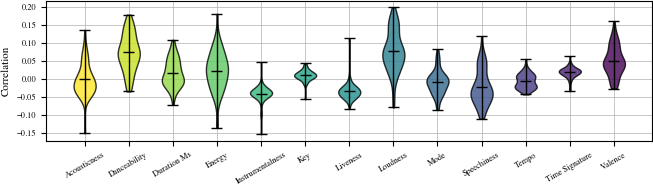

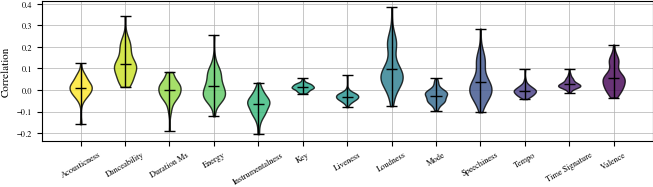

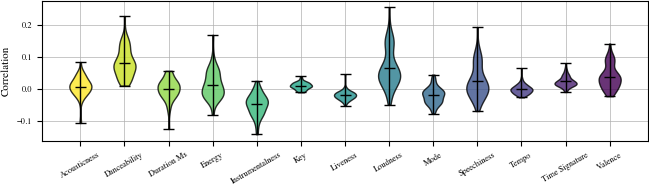

In [6]:

plot_kwargs.update({"column" : "full", "nrows" : 0.5, "ncols" : 1})

# Plot the correlation of all regions
for label, df in zip(["Pearson", "Spearman", "Kendall"], [df_corr, df_spearman, df_kendall]):
    reset_plottings(**plot_kwargs)
    plot_correlation(pd.DataFrame(df), method=label, show_extremes=False, show=True,
                    save_path=osp.join(SAVE_DIR, 'corr_plots', f'correlation_{label.lower()}_{PICKLE_LABEL}{SAVE_EXTENSION}'))
    plt.show()

reset_plottings(**plot_kwargs)


It seems that some of the audio features, such as key, liveness, tempo and mode, has almost no correlation. However other audio features has many weak-correlated values. Now we can explore the similarity between regions. 

A similarity between regions are expected since many of the cultures are affected by each other. For example we expect that Southern America should have similar correlations for the audio features. We can use a nice visualization to see the correlations on a world map.

In [7]:
# get number of rows for each country and create a new dataframe
import plotly.express as px
import pycountry

labels = ["Pearson", "Spearman", "Kendall"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})
for df_corr_full,corr_label in zip([pd.DataFrame(df_corr), pd.DataFrame(df_spearman), pd.DataFrame(df_kendall)],labels):

    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr_full).T.reset_index().rename(columns={"index":"Country"}).fillna(0)

    # make index a column as well
    df_corr_full.reset_index(inplace=True)

    # get iso codes and add them to the dataframe
    iso_codes = []
    for country in df_corr_full['Country']:
        try:
            iso_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            iso_codes.append('None')
    df_corr_full['iso_code'] = iso_codes
    # Change the iso code position

    df_corr_full.loc[df_corr_full['Country'] == 'Turkey', 'iso_code'] = 'TUR'

    # Add norm
    df_corr_full['corr_norm'] = np.linalg.norm(
        df_corr_full.iloc[:, 3:-1].values,axis=1)
        
    for feature in df_corr_full.columns[3:]:
        if feature  == "iso_code":
            continue
        reset_plottings(**plot_kwargs)
        
        fig = px.choropleth(df_corr_full, 
                            locations='iso_code', 
                            color=feature, 
                            hover_name='Country',
                            projection='natural earth', 
                            color_continuous_scale='ice',
                            )
        
        # Do not display the legend
        fig.update_layout(coloraxis_colorbar=dict(
            title = audio_feature_to_label(feature),
            len=0.75,
            lenmode='fraction',
        ))
        
        # Save the figure
        save_path = f'world_map_{corr_label}_{PICKLE_LABEL}_{feature}.png'
        fig.write_image(os.path.join(SAVE_DIR,"wmaps",save_path), scale=1)

        # Close the fiugre
        fig.show()



SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


There seems to be a pattern of correlations as shown in the world-map plots. For example South America seems to have a similar tendencies for listening a song more based on a specific choice of audio feature scores as we expected. To consider each of the correlations and their similarity, we use unsupervised clustering methods.

In [8]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,DBSCAN, MeanShift, AffinityPropagation
import plotly

APPLY_DIM_REDUCTION = False
METHOD = "AffinityPropagation"

# Update the mapping for specific labels
country_map = {
    "United States" : "United States of America",
    'Dominican Republic': 'Dominican Rep.',
    'Czech Republic': 'Czechia',
    'Hong Kong' : 'China',
    'Turkey' : 'Türkiye'
}

corr_labels = ["Spearman"]
plot_kwargs.update({"column" : "half", "nrows" : 1, "ncols" : 1})

df_processed_dict = {}

for df_corr_full,corr_label in zip([pd.DataFrame(df_spearman)],corr_labels):

    df_corr_full.drop(columns=['Global'], inplace=True)
    reset_plottings(**plot_kwargs)
    # Merge the world map with your correlation data
    df_corr_full = pd.DataFrame(df_corr_full).T.reset_index().rename(columns={"index":"Country"}).fillna(0)
    
    # Apply PCA to get the first two principal components
    if APPLY_DIM_REDUCTION:
        pca = PCA(n_components=2)

        # Fit the PCA model to the data
        pca_features = pca.fit_transform(df_corr_full.iloc[:,2:])
        fv = pca_features
    else:
        fv = df_corr_full.iloc[:,2:].values

    # get iso codes and add them to the dataframe
    iso_codes = []
    for country in df_corr_full['Country']:
        try:
            iso_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_3)
        except:
            iso_codes.append('None')
    
    df_corr_full['iso_code'] = iso_codes
    # Change the iso code position

    df_corr_full.loc[df_corr_full['Country'] == 'Turkey', 'iso_code'] = 'TUR'


    # Cluster the pca_features
    if METHOD == "KMeans":
        kmeans = KMeans(n_clusters=5, random_state=42)
        kmeans.fit(fv)
        df_corr_full['cluster_label'] = kmeans.labels_
    elif METHOD == "AffinityPropagation":
        affinity_propagation = AffinityPropagation(random_state=42)
        affinity_propagation.fit(fv)
        df_corr_full['cluster_label'] = affinity_propagation.labels_
    elif METHOD == "MeanShift":
        mean_shift = MeanShift(max_iter=500)
        mean_shift.fit(fv)
        df_corr_full['cluster_label'] = mean_shift.labels_
        

    df_processed_dict[corr_label] = df_corr_full
    
    # Plot the correlation on the world map
    fig, ax = plt.subplots(1)
    
    # Remove the colorbar
    reset_plottings(**plot_kwargs)
    
    
    fig = px.choropleth(df_corr_full, 
                        locations='iso_code', 
                        color='cluster_label', 
                        hover_name='Country',
                        projection='natural earth', 
                        color_continuous_scale="viridis_r"
                        )
    
    # Remove the padding
    fig.update_layout(margin={"r":5,"t":0,"l":5,"b":0})
    
    # Do not display the legend
    fig.update_coloraxes(showscale=False) 

    # Save the figure
    save_path = f'world_map_clustering_{corr_label}_{PICKLE_LABEL}{SAVE_EXTENSION}'
    plotly.io.write_image(fig,os.path.join(SAVE_DIR,"wmaps",save_path), format='pdf')

    # Close the fiugre
    fig.show()


SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')


In [9]:
# Print the countries in each cluster

name_to_iso_3 = {}
for label in df_corr_full['cluster_label'].unique():
    countries_label = df_corr_full[df_corr_full['cluster_label'] == label]['Country'].values

    # Print them in a nice way
    iso_3_codes = []
    for country in countries_label:
        try:
            iso_3_codes.append(pycountry.countries.search_fuzzy(country)[0].alpha_2)
            name_to_iso_3[country] = pycountry.countries.search_fuzzy(country)[0].alpha_2
        except:
            if country == 'Turkey':
                iso_3_codes.append('TR')
                name_to_iso_3['Turkey'] = 'TR'
            else:
                iso_3_codes.append('None')

    print([iso for iso in iso_3_codes if iso != 'None'])



SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
SubdivisionHierarchy(code='PA-8', country_code='PA', name='Panamá', parent_code=None, type='Province')
['AR', 'CO', 'BO', 'CL', 'CR', 'DO', 'EC', 'SV', 'GT', 'HN', 'MX', 'PA', 'PY', 'PE', 'ES', 'UY']
['AU', 'DK', 'CZ', 'HU', 'IE', 'IT', 'NZ', 'PL', 'PT', 'SE', 'GB', 'IL', 'RU']
['BR']
['AT', 'BG', 'FI', 'EE', 'FR', 'GR', 'LV', 'LT', 'NL', 'SK', 'EG', 'RO', 'SA', 'UA']
['BE', 'DE', 'IS', 'CH', 'TR', 'IN', 'MA', 'AE']
['CA', 'HK', 'JP', 'MY', 'NO', 'SG', 'TW', 'US', 'VN', 

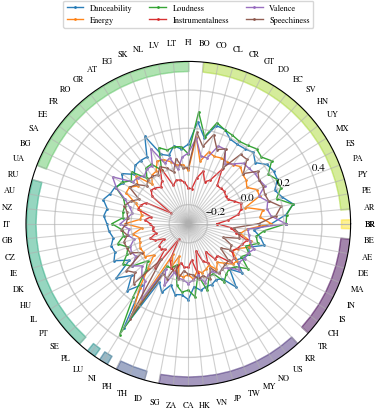

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import pi

plot_kwargs.update({"column" : "full", "nrows" : 1, "ncols" : 1})
reset_plottings(**plot_kwargs)
df = df_processed_dict["Spearman"].set_index('Country')

# Sort by the cluster labels
df = df.sort_values(by=['cluster_label'])

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)

colors = cm.viridis_r(np.linspace(0, 1, len(df['cluster_label'].unique())))

audio_feature_columns = ['danceability', 'energy', 'loudness','instrumentalness','valence','speechiness']

linestyles = ['-', '--', '-.', ':']

for i,audio_feature in enumerate(audio_feature_columns):
    # Assuming df is your DataFrame and 'cluster_label' is the column with cluster labels)
    labels = np.array([name_to_iso_3[idx] for idx in list(df.index)])
    stats = np.array(df.loc[:, audio_feature].values)
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    stats = np.concatenate((stats,[stats[0]]))
    labels  = np.concatenate((labels,[labels[0]]))
    angles = np.concatenate((angles,[angles[0]]))

    ax.plot(angles, stats, 'o-', linewidth=1, zorder=0,markersize=1, label=audio_feature_to_label(audio_feature), alpha = 0.95)    # ax.fill_between(angles, stats, [-0.2] * len(stats), alpha=0.25)
    ax.grid(True)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    # Fill the specific clusters with a color
    for i, cluster_label in enumerate(df['cluster_label'].unique()):
        df_cluster = df[df['cluster_label'] == cluster_label]
        stats_cluster = np.array(df_cluster.loc[:, audio_feature].values)
        angles_cluster = angles[:-1][df['cluster_label'] == cluster_label]
        if len(angles_cluster) == 1:
            ax.fill_between([angles_cluster[0] - 1/(4*len(df['cluster_label'].unique())),
                             angles_cluster[0] + 1/(4*len(df['cluster_label'].unique()))], 0.55, 0.50, color=colors[i], alpha=0.1)
        
        else:
            ax.fill_between(angles_cluster, 0.55, 0.50, color=colors[i], alpha=0.1)

    # Fill the specific clusters with a color
    plt.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.2),
        ncol=3,
        fancybox=True,
    )
    # Normalize the y ticks between -1 and 1
    ax.set_ylim(-0.3,0.55)
    ax.set_yticks([-0.2, 0, 0.2, 0.4], minor=False)
    ax.tick_params(axis='y', which='major', labelsize=8, labelcolor='black', pad=10,
                   width=3, grid_linewidth=1, labelright=True)
    ax.grid(alpha=0.60)
        
plt.savefig(os.path.join(SAVE_DIR,"wmaps",f"radar_plot_{PICKLE_LABEL}{SAVE_EXTENSION}"))
plt.show()